## Hi there!

This notebook includes native implementation of REINFORCE algorithm. We compute gradients on our own, implement gradient descent and set the policy function. Used methods and functions differ from those, that we described in the report. This notebook is created to see that happens under the hood of REINFORCE. 

The code is based on: https://medium.com/samkirkiles/reinforce-policy-gradients-from-scratch-in-numpy-6a09ae0dfe12


In [271]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import copy 

Set the hyperparameters for REINFORCE. Choose wisely:)

In [272]:
#Hyperparameters
NUM_EPISODES = 10000 # maximum number of episode
LEARNING_RATE = 0.0005 # learning rate
GAMMA = 0.99 # discount rate for discounted value function

Ctrate the environment and investigate it

In [273]:
# Create gym and seed numpy
env = gym.make('CartPole-v0') # LunarLander-v2  # CartPole-v0
nA = env.action_space.n
np.random.seed(1)

In [274]:
print("Chosen environment has {}-shape states".format(env.observation_space.shape[0]))
print("There is {} possible actions to choose".format(env.action_space.n))

Chosen environment has 4-shape states
There is 2 possible actions to choose


In [275]:
print("The initail state is {}". format(env.reset()))

The initail state is [0.03646576 0.01810739 0.0421362  0.04167161]


Now we will intitialize the policy function - Softmax function. This function was chosen because it is easy to find the derivative analiticaly. If you are interested how to find derivative, there is a step-by-step explanation: https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/

In [276]:
# Our policy that maps state to action parameterized by w
def policy(state,w):
    z = state.dot(w)
    exp = np.exp(z)
    return exp/np.sum(exp)

# Vectorized softmax Jacobian
def softmax_grad(softmax):
    s = softmax.reshape(-1,1)
    return np.diagflat(s) - np.dot(s, s.T)

Before starting episode we need to initialize parameters $\theta$.

In [277]:
# Init weight
w = np.random.rand(env.observation_space.shape[0], env.action_space.n)

Now we run one step in the environment and see what are the variables.

In [278]:
state = env.reset()[None,:] # reshape state
probs = policy(state,w)  # find probabilities of do the action from policy 
action = np.random.choice(nA,p=probs[0])  # sample the action 
next_state,reward,done,_ = env.step(action)  # make the action in the environment and get the feedback
next_state = next_state[None,:]  # reshape state

# Compute gradient 
dsoftmax = softmax_grad(probs)[action,:]
dlog = dsoftmax / probs[0,action]
grad = state.T.dot(dlog[None,:])

This is probabilities that was generated by policy

In [279]:
probs

array([[0.49531172, 0.50468828]])

The agent chooses this action

In [280]:
action

0

The environment put us in a new state

In [281]:
state

array([[ 0.00880941,  0.03585422, -0.00822777,  0.03012052]])

And gave reward to agent (or not)

In [282]:
reward

1.0

And we computed such gradient (Jacobian)

In [283]:
grad

array([[ 0.00444601, -0.00444601],
       [ 0.01809521, -0.01809521],
       [-0.00415246,  0.00415246],
       [ 0.01520147, -0.01520147]])

### Now it is time to run the learning! 

We initialize all the variables again. Note:

1. The process ends whan: 

    (a) we reach the maximum of episodes
    
    (b) mean of the last 100 episode rewards is more than 200 (you can change this parameter accoding to your preferences)
    
2. At first we run all the steps of the episode, remember the results. When the episode ends, we recompute the weights.

By default maximum steps is set. You can change it if you want

In [284]:
env._max_episode_steps

200

In [285]:
# Init weight
w = np.random.rand(env.observation_space.shape[0], env.action_space.n)

# Keep rewards for final plot of convergence
episode_rewards = []

# Count the steps that was made in all the episodes
count_steps = 0
for e in range(NUM_EPISODES):
    state = env.reset()[None,:]
    
    # For each episode we need to remember the gradients and rewards that was found on each step 
    grads = []
    rewards = []
    
    # Keep track of game score to print
    score = 0
    while True:
        count_steps += 1
        
        # Uncomment to see your model train in real time (slower)
        #env.render()
        
        # Make the step as we did earlier
        probs = policy(state,w)
        action = np.random.choice(nA,p=probs[0])
        next_state,reward,done,_ = env.step(action)
        next_state = next_state[None,:]

        dsoftmax = softmax_grad(probs)[action,:]
        dlog = dsoftmax / probs[0,action]
        grad = state.T.dot(dlog[None,:])

        # Remember the results
        grads.append(grad)
        rewards.append(reward)
        score+=reward

        # Dont forget to update your old state to the new state
        state = next_state
        if done:
            break
            
    # Weight update after the episode
    for i in range(len(grads)):

        # Loop through everything that happend in the episode and update towards the log policy gradient times **FUTURE** reward
        w += LEARNING_RATE * grads[i] * sum([ r * (GAMMA ** r) for t,r in enumerate(rewards[i:])])

    # Append for logging and print
    episode_rewards.append(score)
    # check if the process converged
    if np.mean(episode_rewards[-100:]) >= 195:
        break
    
    # Uncomment to see printed rewards on each episode
    #print("EP: " + str(e) + " Score: " + str(score)) 

In [286]:
# total number of steps
count_steps

76962

Draw the results

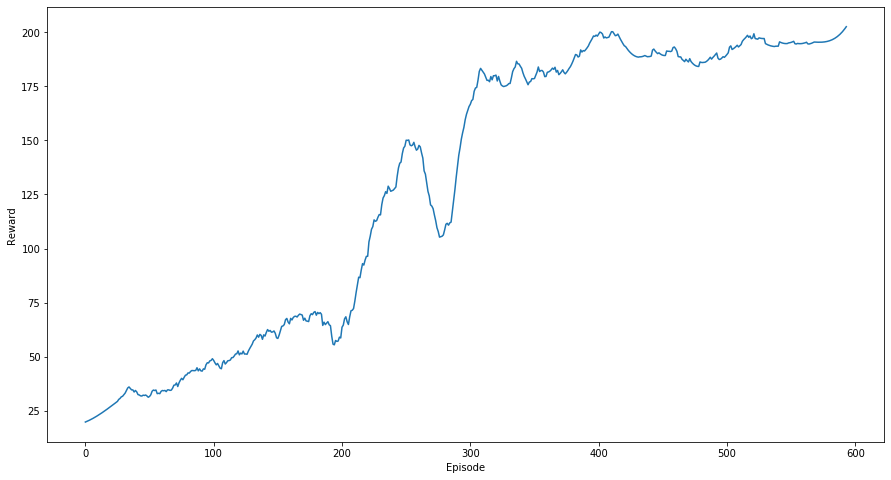

In [287]:
from scipy.signal import savgol_filter # to smooth the rewards

plt.figure(figsize = (15,8))
plt.plot(np.arange(e+1),savgol_filter(episode_rewards, 51, 3))
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

In [288]:
# close the environment 
env.close()